In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans

# Compile the Cython modules with 
# python setup.py build_ext --inplace
from tsp import tsp_path_solver as c_tsp_path_solver
from tsp import lagging_neighbor_path_py 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


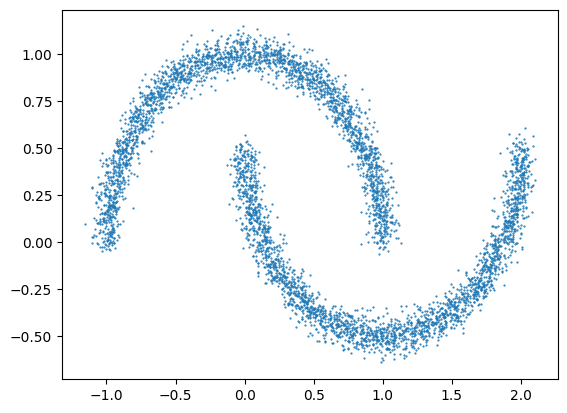

In [3]:
n = 5000
rs = 1337

# Get some sample data
noisy_moons = datasets.make_moons(n_samples=n, noise=0.05, random_state=rs)
points = noisy_moons[0]

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], s=0.3)

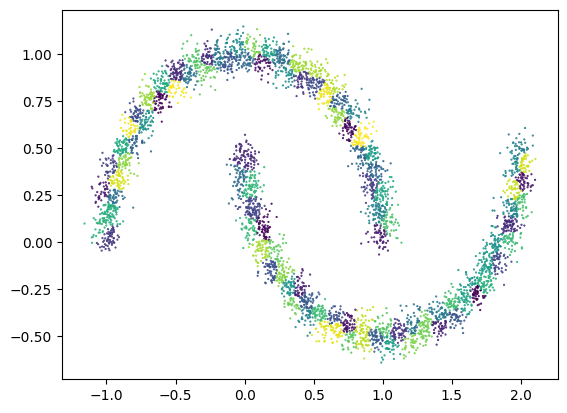

In [4]:
# Run KMeans clustering to coarse-grain the points
kmeans = KMeans(n_clusters=round(len(points) / 50 ), random_state=1337).fit(points)

# Notice that the points are un-ordered
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=kmeans.labels_, s=0.3)

64 [-1.04896338  0.09079734]


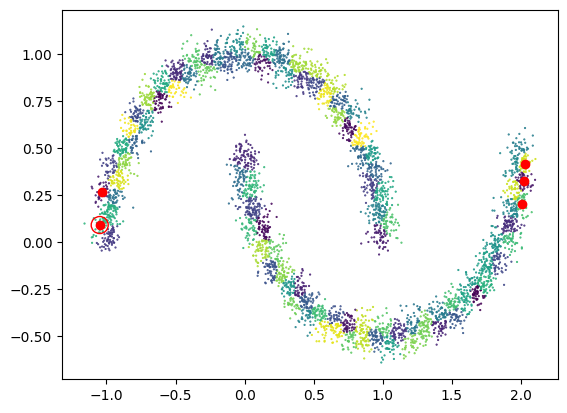

In [5]:
# Figure out an 'end' of the data
def neigborhood_anisotropy(centroids):
    # the ends of the structure have the most anisotropic neighborhoods
    # Use a simple linear falloff of the distance to weight neighbors more
    centroid_vectors = centroids[:, None] - centroids[None, :]
    with np.errstate(invalid='ignore'): # The norms of the diag are all 0
        centroid_vectors /= (2 * np.linalg.norm(centroid_vectors, axis=2))[:, :, None]
    np.nan_to_num(centroid_vectors, copy=False)
    aniso = np.sum(centroid_vectors, axis=1)
    aniso = np.linalg.norm(aniso, axis=1)
    return aniso

centroids = kmeans.cluster_centers_
aniso = neigborhood_anisotropy(centroids)
best = np.argpartition(aniso, -5)[-5:]

# Arbitrarily, let's pick the best one with the smallest x-coordinate
ref_idx = best[np.argmin(centroids[best][:,0])]
print(ref_idx, centroids[ref_idx])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=kmeans.labels_, s=0.3)
ax.scatter(centroids[best][:,0], centroids[best][:,1], c='r')
ax.scatter(centroids[ref_idx][0], centroids[ref_idx][1], s=150, facecolors='none', edgecolors='r')


Nearest neighbor path distance: 61.2925
Edge statistics - Min: 0.0812, Max: 2.3436, Avg: 0.6191


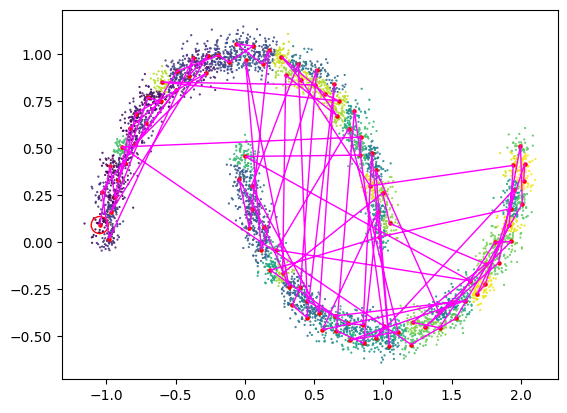

In [6]:
# Re-order centroids using the dumb lagging mean method
# This works okay when you have a single long blob (like RNA atoms)
centroids = centroids.astype(np.float64)
new_labels = lagging_neighbor_path_py(centroids, ref_idx) 

# Re-label the points
ordered_centroids = centroids[new_labels]
new_point_labels = np.array([np.argwhere(new_labels==l) for l in kmeans.labels_])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=new_point_labels, s=0.3)
ax.scatter(ordered_centroids[:,0], ordered_centroids[:,1], c='r', s=5)
ax.plot(ordered_centroids[:,0], ordered_centroids[:,1], c='magenta', linewidth=1)
ax.scatter(ordered_centroids[0][0], ordered_centroids[0][1], s=150, facecolors='none', edgecolors='r')


Solving TSP for 100 nodes starting from index 64
Step 1: Finding greedy nearest neighbor solution...
Nearest neighbor path distance: 61.2925
Edge statistics - Min: 0.0812, Max: 2.3436, Avg: 0.6191

Step 2: Running simulated annealing optimization...
Starting simulated annealing with initial cost: 61.2925
Iteration 0: Current cost = 61.4783, Best cost = 61.2925, Temperature = 1.232042, Longest step = 2.3435598479605306 at position 67
Iteration 10000: Current cost = 19.6167, Best cost = 19.6167, Temperature = 0.000000, Longest step = 1.102579989662145 at position 54
Iteration 20000: Current cost = 109.4327, Best cost = 19.4047, Temperature = 1.473726, Longest step = 2.9126701728049875 at position 66
Iteration 30000: Current cost = 123.5771, Best cost = 19.4047, Temperature = 2.689349, Longest step = 2.8240206900568774 at position 4
Iteration 40000: Current cost = 126.1934, Best cost = 19.4047, Temperature = 4.907694, Longest step = 2.9715544181638296 at position 17
Iteration 50000: Curre

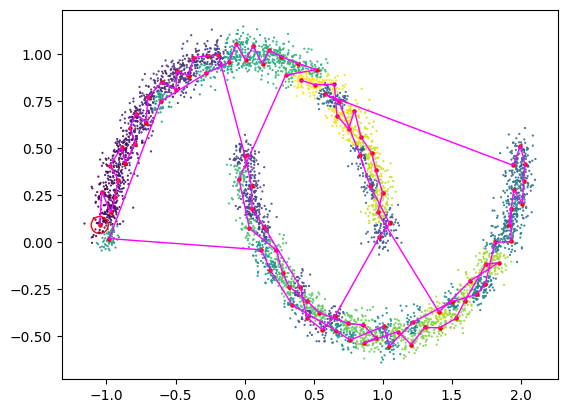

In [7]:
# Re-order centroids using simulated annealing to optimize the points
centroids = centroids.astype(np.float64)
new_labels = c_tsp_path_solver(centroids, ref_idx, max_iterations=10000000) 

# Re-label the points
ordered_centroids = centroids[new_labels]
new_point_labels = np.array([np.argwhere(new_labels==l) for l in kmeans.labels_])

fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1], c=new_point_labels, s=0.3)
ax.scatter(ordered_centroids[:,0], ordered_centroids[:,1], c='r', s=5)
ax.plot(ordered_centroids[:,0], ordered_centroids[:,1], c='magenta', linewidth=1)
ax.scatter(ordered_centroids[0][0], ordered_centroids[0][1], s=150, facecolors='none', edgecolors='r')